In [1]:
# Import libraries
# GoogleNews Documentation : https://pypi.org/project/GoogleNews/
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
from tqdm import tqdm
import pandas as pd
import nltk  # NLP library
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pyLDAvis.gensim_models
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import warnings

warnings.filterwarnings('ignore')
sns.set()
pyLDAvis.enable_notebook()

In [2]:
# This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anna_verbytska/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Config to avoid 403 forbidden error
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 20

In [4]:
# Initializing
googlenews = GoogleNews()

In [5]:
# Clear previous search
googlenews.clear()

In [34]:
# Settings
googlenews = GoogleNews(lang='en',start='01/08/2023',end='01/08/2023')

In [35]:
# Search 
googlenews.search('Ukraine')
print(f"Articles found:", googlenews.total_count())

Articles found: 39


In [36]:
# Results
result = googlenews.result()

In [37]:
# Convert to DataFrame
df = pd.DataFrame(result)
df.head(20)

,title,media,date,datetime,desc,link,img
0,,,,NaT,,https://support.google.com/websearch/answer/10...,
1,"Ukraine updates: Russia 'cease-fire' ends, str...",DW,1 month ago,2023-01-10 17:56:43.191954,Russian bombings overnight killed at least one...,https://www.dw.com/en/ukraine-updates-russia-s...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
2,Russia-Ukraine war at a glance: what we know o...,The Guardian,1 month ago,2023-01-10 17:56:43.199156,Market attack leaves at least two people dead;...,https://www.theguardian.com/world/2023/jan/09/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
3,"Moscow Ends Self-proclaimed Ceasefire, Vows to...",Asharq AL-awsat,1 month ago,2023-01-10 17:56:43.205364,Most Ukrainian Orthodox Christians have tradit...,https://english.aawsat.com/home/article/408651...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
4,Ukraine denies Russian claim of 600 killed in ...,EURACTIV.com,1 month ago,2023-01-10 17:56:43.211209,"Russia launched seven missile strikes, 31 air ...",https://www.euractiv.com/section/global-europe...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
5,"Russia-Ukraine Latest News: January 8, 2023",Bloomberg.com,1 month ago,2023-01-10 17:56:43.216606,"Earlier Sunday, Kyiv rejected as “nonsense” a ...",https://www.bloomberg.com/news/articles/2023-0...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
6,Ukraine war latest: ‘Very difficult’ situation...,Yahoo News,1 month ago,2023-01-10 17:56:43.221604,"Ukrainian forces, mainly composed of mobilized...",https://news.yahoo.com/ukraine-war-latest-very...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
7,Missiles and air strikes hit Ukraine targets a...,Financial Times,1 month ago,2023-01-10 17:56:43.226714,Moscow said Ukrainian missile strikes had hit ...,https://www.ft.com/content/40b485c4-4198-44c4-...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
8,Donating tanks to Ukraine gathers growing supp...,EURACTIV.com,1 month ago,2023-01-10 17:56:43.231493,"As was previously the case, the shipment's con...",https://www.euractiv.com/section/politics/news...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
9,Ukraine/Russland/NATO – der Sammler am 8. Janu...,Augen geradeaus!,1 month ago,2023-01-10 17:56:43.235955,Die Ukraine äußerte sich zu dieser russischen ...,https://augengeradeaus.net/2023/01/ukraine-rus...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."


In [38]:
# Checking one article
df.iloc[8]['desc']

"As was previously the case, the shipment's contents will not be disclosed for security reasons. Finland's military aid to Ukraine since the war started amounts..."

In [39]:
# Unfortunately there is a search limit on the number of news in this api. Maximum number is 10. Now, we will try to fetch more than that.
for i in tqdm(range(2,10), colour="red", desc="Getting news links from Google"):
  googlenews.getpage(i)
  result = googlenews.result()
  df = pd.DataFrame(result)

Getting news links from Google: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


In [40]:
df.head(15)

,title,media,date,datetime,desc,link,img
0,,,,NaT,,https://support.google.com/websearch/answer/10...,
1,"Ukraine updates: Russia 'cease-fire' ends, str...",DW,1 month ago,2023-01-10 17:56:43.191954,Russian bombings overnight killed at least one...,https://www.dw.com/en/ukraine-updates-russia-s...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
2,Russia-Ukraine war at a glance: what we know o...,The Guardian,1 month ago,2023-01-10 17:56:43.199156,Market attack leaves at least two people dead;...,https://www.theguardian.com/world/2023/jan/09/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
3,"Moscow Ends Self-proclaimed Ceasefire, Vows to...",Asharq AL-awsat,1 month ago,2023-01-10 17:56:43.205364,Most Ukrainian Orthodox Christians have tradit...,https://english.aawsat.com/home/article/408651...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
4,Ukraine denies Russian claim of 600 killed in ...,EURACTIV.com,1 month ago,2023-01-10 17:56:43.211209,"Russia launched seven missile strikes, 31 air ...",https://www.euractiv.com/section/global-europe...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
5,"Russia-Ukraine Latest News: January 8, 2023",Bloomberg.com,1 month ago,2023-01-10 17:56:43.216606,"Earlier Sunday, Kyiv rejected as “nonsense” a ...",https://www.bloomberg.com/news/articles/2023-0...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
6,Ukraine war latest: ‘Very difficult’ situation...,Yahoo News,1 month ago,2023-01-10 17:56:43.221604,"Ukrainian forces, mainly composed of mobilized...",https://news.yahoo.com/ukraine-war-latest-very...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
7,Missiles and air strikes hit Ukraine targets a...,Financial Times,1 month ago,2023-01-10 17:56:43.226714,Moscow said Ukrainian missile strikes had hit ...,https://www.ft.com/content/40b485c4-4198-44c4-...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
8,Donating tanks to Ukraine gathers growing supp...,EURACTIV.com,1 month ago,2023-01-10 17:56:43.231493,"As was previously the case, the shipment's con...",https://www.euractiv.com/section/politics/news...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
9,Ukraine/Russland/NATO – der Sammler am 8. Janu...,Augen geradeaus!,1 month ago,2023-01-10 17:56:43.235955,Die Ukraine äußerte sich zu dieser russischen ...,https://augengeradeaus.net/2023/01/ukraine-rus...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."


In [41]:
# Remove some weird rows
df = df[df['datetime'].notnull()]
df.head(15)

,title,media,date,datetime,desc,link,img
1,"Ukraine updates: Russia 'cease-fire' ends, str...",DW,1 month ago,2023-01-10 17:56:43.191954,Russian bombings overnight killed at least one...,https://www.dw.com/en/ukraine-updates-russia-s...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
2,Russia-Ukraine war at a glance: what we know o...,The Guardian,1 month ago,2023-01-10 17:56:43.199156,Market attack leaves at least two people dead;...,https://www.theguardian.com/world/2023/jan/09/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
3,"Moscow Ends Self-proclaimed Ceasefire, Vows to...",Asharq AL-awsat,1 month ago,2023-01-10 17:56:43.205364,Most Ukrainian Orthodox Christians have tradit...,https://english.aawsat.com/home/article/408651...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
4,Ukraine denies Russian claim of 600 killed in ...,EURACTIV.com,1 month ago,2023-01-10 17:56:43.211209,"Russia launched seven missile strikes, 31 air ...",https://www.euractiv.com/section/global-europe...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
5,"Russia-Ukraine Latest News: January 8, 2023",Bloomberg.com,1 month ago,2023-01-10 17:56:43.216606,"Earlier Sunday, Kyiv rejected as “nonsense” a ...",https://www.bloomberg.com/news/articles/2023-0...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
6,Ukraine war latest: ‘Very difficult’ situation...,Yahoo News,1 month ago,2023-01-10 17:56:43.221604,"Ukrainian forces, mainly composed of mobilized...",https://news.yahoo.com/ukraine-war-latest-very...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
7,Missiles and air strikes hit Ukraine targets a...,Financial Times,1 month ago,2023-01-10 17:56:43.226714,Moscow said Ukrainian missile strikes had hit ...,https://www.ft.com/content/40b485c4-4198-44c4-...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
8,Donating tanks to Ukraine gathers growing supp...,EURACTIV.com,1 month ago,2023-01-10 17:56:43.231493,"As was previously the case, the shipment's con...",https://www.euractiv.com/section/politics/news...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
9,Ukraine/Russland/NATO – der Sammler am 8. Janu...,Augen geradeaus!,1 month ago,2023-01-10 17:56:43.235955,Die Ukraine äußerte sich zu dieser russischen ...,https://augengeradeaus.net/2023/01/ukraine-rus...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
10,Ukrainian Christmas: Hundreds attend celebrati...,BBC,1 month ago,2023-01-10 17:56:43.240219,"There are at least 1,842 Ukrainian refugees in...",https://www.bbc.com/news/uk-northern-ireland-6...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."


In [42]:
# Get the full article extracting and parsing the article and drop the links that give problems

list = []

for ind in tqdm(df.index, colour="green", desc="Extracting articles from the internet"):
  dict = {}
  
  try:
    article = Article(df['link'][ind],config = config)
    article.download()
    article.parse()
    article.nlp()
    dict['Date'] = df['date'][ind]
    dict['Media'] = df['media'][ind]
    dict['Title'] = article.title
    dict['Article'] = article.text
    dict['Summary'] = article.summary
    list.append(dict)
  except Exception:
    df.drop([ind],axis=0,inplace=True)



Extracting articles from the internet: 100%|██████████| 81/81 [01:16<00:00,  1.06it/s]


In [43]:
# Create the news dataframe with full articles
news_df = pd.DataFrame(list)
news_df.head(20)

,Date,Media,Title,Article,Summary
0,1 month ago,DW,"Ukraine updates: Russia 'cease-fire' ends, str...",Russian bombings overnight killed at least one...,Russian bombings overnight killed at least one...
1,1 month ago,The Guardian,Russia-Ukraine war at a glance: what we know o...,Two women were killed and several other people...,Two women were killed and several other people...
2,1 month ago,Asharq AL-awsat,"Moscow Ends Self-proclaimed Ceasefire, Vows to...",FILE PHOTO: Plumes of smoke rise from a Russia...,FILE PHOTO: Plumes of smoke rise from a Russia...
3,1 month ago,EURACTIV.com,Ukraine denies Russian claim of 600 killed in ...,Ukrainian forces are repelling constant Russia...,Ukrainian forces are repelling constant Russia...
4,1 month ago,Bloomberg.com,Are you a robot?,Why did this happen?\n\nPlease make sure your ...,Why did this happen?\nPlease make sure your br...
5,1 month ago,Yahoo News,Ukraine war latest: ‘Very difficult’ situation...,Key developments on Jan. 8:\n\nRussian forces ...,“They (Russian troops) concentrated considerab...
6,1 month ago,Financial Times,Subscribe to read,What is included in my trial?\n\nDuring your t...,During your trial you will have complete digit...
7,1 month ago,EURACTIV.com,Donating tanks to Ukraine gathers growing supp...,Discussions about donating tanks to Ukraine is...,Discussions about donating tanks to Ukraine is...
8,1 month ago,Augen geradeaus!,NATO – der Sammler am 8. Januar 2023 – Augen g...,Zum andauernden russischen Angriffskrieg gegen...,"Bakhmut axis: Berestove, Bilohorivka, Vesele, ..."
9,1 month ago,BBC,Ukrainian Christmas: Hundreds attend celebrati...,"""It is very important to remind people that we...","""It is very important to remind people that we..."


In [44]:
# Checking one article
news_df.iloc[8]['Article']

'Zum andauernden russischen Angriffskrieg gegen die Ukraine der Sammler am 8. Januar 2023:\n\n• Nach Darstellung des russischen Verteidigungsministeriums sollen bei einem Raketenangriff auf die Unterkünfte ukrainischer Truppen in Kramatorsk 600 Ukrainer gefallen sein – und vor allem: dieser Angriff sei eine, ausdrücklich so bezeichnet, Vergeltungsaktion (retaliatory operation) für den Angriff auf eine russische Truppenunterkunft in Makiivka gewesen. Dabei waren in der Silvesternacht nach russischen Angaben 89, nach ukrainischen Angaben über 400 russische Soldaten getötet worden. (s. dazu den letzten Absatz des russischen Briefings unten)\n\nDie Ukraine äußerte sich zu dieser russischen Behauptung nicht. Mehrere ausländische Journalisten besuchten die Orte der angeblichen russischen Angriffsziele in Kramatorsk, fanden allerdings keine Belege für die behaupteten Einschläge. Aus der Meldung von Reuters:\n\nA Russian rocket strike on the Ukrainian city of Kramatorsk caused damage but did n

# Topic Modelling

In [45]:
#Running a model
nlp = en_core_web_md.load()

In [46]:
#Removing stopwords
removal= ['PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

In [47]:
#Lemmatization & tokenization
tokens = []
for article in nlp.pipe(news_df['Article']):
	proj_tok = [token.lemma_.lower() for token in article if token.pos_ not in removal and not token.is_stop and token.is_alpha]
	tokens.append(proj_tok)

In [48]:
#Printing out tokens
news_df['tokens'] = tokens
news_df['tokens']

0     [russian, bombing, overnight, kill, eastern, u...
1     [woman, kill, people, wound, russian, missile,...
2     [file, photo, plume, smoke, rise, russian, str...
3     [ukrainian, force, repel, constant, russian, a...
4     [happen, sure, browser, support, javascript, c...
                            ...                        
67                                                   []
68    [wild, goaltender, marc, andre, fleury, expect...
69    [wout, weghorst, besiktas, credit, alamy, burn...
70    [boston, ap, husband, miss, massachusetts, wom...
71    [federal, prosecutor, glenn, kirschner, think,...
Name: tokens, Length: 72, dtype: object

In [49]:
#Creating a dictionary, giving each token a unique ID
dictionary = Dictionary(news_df['tokens'])
print(dictionary.token2id)

{'able': 0, 'accord': 1, 'acknowledge': 2, 'add': 3, 'administrative': 4, 'affect': 5, 'afp': 6, 'agency': 7, 'aid': 8, 'ally': 9, 'anna': 10, 'answer': 11, 'ap': 12, 'appear': 13, 'armed': 14, 'artist': 15, 'asset': 16, 'assist': 17, 'associated': 18, 'attack': 19, 'bakhmut': 20, 'barrack': 21, 'big': 22, 'blast': 23, 'blood': 24, 'body': 25, 'bombing': 26, 'bring': 27, 'browser': 28, 'call': 29, 'carry': 30, 'casualty': 31, 'cease': 32, 'center': 33, 'channel': 34, 'cherevatyi': 35, 'chief': 36, 'christmas': 37, 'church': 38, 'city': 39, 'citzenship': 40, 'civilian': 41, 'claim': 42, 'clergy': 43, 'close': 44, 'college': 45, 'come': 46, 'comment': 47, 'completely': 48, 'concern': 49, 'confirm': 50, 'consider': 51, 'continue': 52, 'control': 53, 'country': 54, 'crisis': 55, 'cut': 56, 'damage': 57, 'day': 58, 'december': 59, 'declare': 60, 'defense': 61, 'definitely': 62, 'deny': 63, 'deputy': 64, 'describe': 65, 'despite': 66, 'development': 67, 'die': 68, 'directly': 69, 'displace':

In [50]:
#Filtering out low-frequency and high-frequency tokens, also limit the vocabulary to a max of 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [51]:
#Creating a corpus
corpus = [dictionary.doc2bow(doc) for doc in news_df['tokens']]

In [52]:
#Building a model with LDA that represents topics as word probabilities and allows for uncovering latent or hidden topics as it clusters the words based on their co-occurrence in a respective document
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

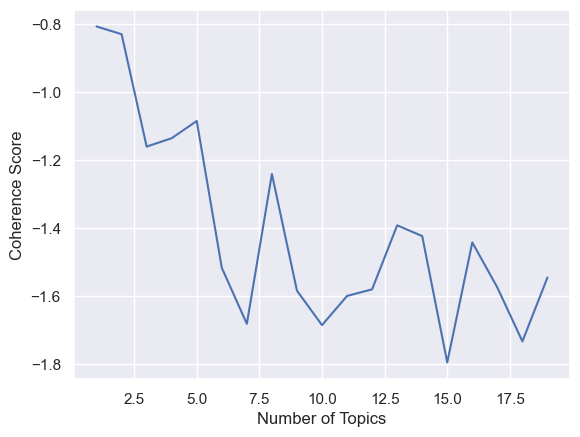

In [53]:
#Calculating the coherence score using C_umass to measure the degree of semantic similarity between high scoring words in each topic
topics = []
score = []
for i in range (1,20,1):   
  lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)   
  cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')   
  topics.append(i)
  score.append(cm.get_coherence())
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

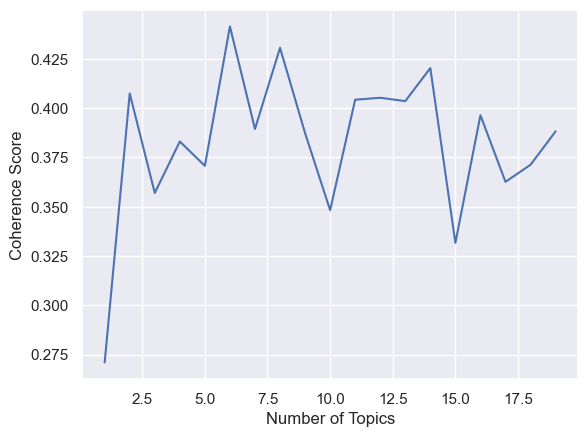

In [54]:
#Calculating the coherence score using C_v
topics = []
score = []
for i in range(1,20,1):  
  lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)   
  cm = CoherenceModel(model=lda_model, texts = news_df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')   
  topics.append(i)
  score.append(cm.get_coherence())
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [55]:
#Printing out the results
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=6, workers = 4, passes=100)
for top in lda_model.print_topics(10):
  print(top)

(0, '0.024*"act" + 0.019*"accord" + 0.019*"child" + 0.017*"new" + 0.017*"civilian" + 0.013*"nato" + 0.013*"hold" + 0.012*"report" + 0.012*"ask" + 0.011*"conflict"')
(1, '0.020*"putin" + 0.017*"president" + 0.012*"vladimir" + 0.011*"force" + 0.011*"offensive" + 0.011*"zelensky" + 0.011*"accord" + 0.011*"include" + 0.011*"defense" + 0.010*"report"')
(2, '0.025*"oblast" + 0.021*"force" + 0.019*"defense" + 0.019*"troop" + 0.018*"attack" + 0.017*"air" + 0.017*"donetsk" + 0.015*"missile" + 0.014*"strike" + 0.013*"people"')
(3, '0.014*"tank" + 0.012*"refugee" + 0.011*"time" + 0.011*"people" + 0.009*"work" + 0.009*"world" + 0.008*"support" + 0.008*"good" + 0.008*"europe" + 0.008*"end"')
(4, '0.018*"moscow" + 0.018*"city" + 0.015*"soldier" + 0.015*"eastern" + 0.015*"report" + 0.014*"region" + 0.014*"orthodox" + 0.014*"kill" + 0.014*"kyiv" + 0.013*"putin"')
(5, '0.023*"nato" + 0.020*"tank" + 0.016*"vehicle" + 0.015*"missile" + 0.013*"supply" + 0.009*"force" + 0.009*"defence" + 0.009*"security" +

In [56]:
#Distribution of topics in a document
lda_model[corpus][0]

[(4, 0.99775374)]

In [57]:
#Visualization of topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [58]:
#Creating a new column for topics
news_df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(news_df['Article']))]

In [59]:
#Counting frequency of every topic in a document
news_df.topic.value_counts()

1    19
0    18
3    17
2     7
5     6
4     5
Name: topic, dtype: int64

In [60]:
news_df.head()

,Date,Media,Title,Article,Summary,tokens,topic
0,1 month ago,DW,"Ukraine updates: Russia 'cease-fire' ends, str...",Russian bombings overnight killed at least one...,Russian bombings overnight killed at least one...,"[russian, bombing, overnight, kill, eastern, u...",4
1,1 month ago,The Guardian,Russia-Ukraine war at a glance: what we know o...,Two women were killed and several other people...,Two women were killed and several other people...,"[woman, kill, people, wound, russian, missile,...",0
2,1 month ago,Asharq AL-awsat,"Moscow Ends Self-proclaimed Ceasefire, Vows to...",FILE PHOTO: Plumes of smoke rise from a Russia...,FILE PHOTO: Plumes of smoke rise from a Russia...,"[file, photo, plume, smoke, rise, russian, str...",4
3,1 month ago,EURACTIV.com,Ukraine denies Russian claim of 600 killed in ...,Ukrainian forces are repelling constant Russia...,Ukrainian forces are repelling constant Russia...,"[ukrainian, force, repel, constant, russian, a...",2
4,1 month ago,Bloomberg.com,Are you a robot?,Why did this happen?\n\nPlease make sure your ...,Why did this happen?\nPlease make sure your br...,"[happen, sure, browser, support, javascript, c...",0
